In [7]:
import os
import pickle as pkl
import glob
import random
random.seed(0)

import pandas as pd
import numpy as np
np.random.seed(0)

from scipy.stats import pearsonr
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics  import mean_squared_error, r2_score, root_mean_squared_error, median_absolute_error

import umap
import Levenshtein

import torch
torch.manual_seed(0)
torch.use_deterministic_algorithms(False)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics import R2Score


import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def check_test_split(seq_train, seq_test):

    miss = set()
    for i, train in enumerate(seq_train):
        for j, test in enumerate(seq_test):
            if Levenshtein.ratio(train,test) > 0.95:
                miss.add(j) 

    return list(miss)


def scatter_density(x, y,ax, gauss_kern_bandwidth=0.05, **kwargs):
   """
   Scatter plot with density coloring using matplotlib.
   kwargs are passed to the pyplot.scatter() function,
   with defaults s = 4 and cmap = 'plasma'
   """
   xy = np.vstack([x, y])
   z = stats.gaussian_kde(xy, bw_method=gauss_kern_bandwidth)(xy)

   # Sort the points by density, so that the densest points are plotted last
   idx = z.argsort()
   x, y, z = x[idx], y[idx], z[idx]

   if 's' not in kwargs:
       kwargs['s'] = 4
   if 'cmap' not in kwargs:
       kwargs['cmap'] = 'plasma'

   ax.scatter(x, y, c=z, **kwargs)

organism_dict = {"353153":"T.cruzi",
                "9031":"G.gallus",
                "8355": "X.laevis",
                "9823":"S.scrofa",
                "9913":"B.taurus",
                "449447":"M.aeruginosa",
                "511145":"E.coli",
                "9606":"H.sapiens",
                "272623":"L.lactis",
                "83332":"M.tuberculosis",
                "10090":"M.musculus",
                "189518":"L.interrogans",
                "4577":"Z.mays",
                "64091":"H.salinarum",
                "284590":"K.lactis",
                "4932": "S.cerevisiae",
                "67767":"L.niger",
                "39947":"O.satival",
                "246200":"R.pomeroyi",
                "243159":"A.ferrooxidans",
                "9544":"M.mulatta",
                "1286170":"R.ornithinolytica",
                "7227":"D.melanogaster",
                "ho2018":"S.cerevisiae_Ho2018"}


SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Load embeddings

In [40]:



files = glob.glob("../../data/PaxDb/data_sets/embedding_esm/*")
dfs = {}
organisms = []
for file in files:
    if file[-3:] != "pkl":
        continue
    with open(file, "br") as f:
        organism = file.split("/")[-1].split("_")[0]
        if organism in ["83332"] or organism in list(dfs.keys()):
            continue

        print(f"Appending file {file}")
        tmp_df = pkl.load(f)
        if len(tmp_df['id']) < 10:
            print(f"File: {file} does not have enoghe entries with: {len(tmp_df['id'])} entries")
            continue
        tmp_df["Embedding"] = tmp_df["Embedding"][:len(tmp_df["id"])]
        
        dfs[organism] = {"id": tmp_df["id"],
                         "seq": tmp_df["seq"],
                         "abundance": tmp_df["TM"],
                         "Embeddings":tmp_df["Embedding"]}

        if organism == "ho2018":
            X_train, X_test, y_train, y_test = train_test_split(tmp_df["Embedding"].to_list(), tmp_df["TM"].to_list(), test_size=0.2, random_state=42)
            id_train, id_test, seq_train, seq_test = train_test_split(tmp_df["id"].to_list(), tmp_df["seq"].to_list(), test_size=0.2, random_state=42)
        else:
            X_train, X_test, y_train, y_test = train_test_split(tmp_df["Embedding"], tmp_df["TM"], test_size=0.2, random_state=42)
            id_train, id_test, seq_train, seq_test = train_test_split(tmp_df["id"], tmp_df["seq"], test_size=0.2, random_state=42)

        

        miss = check_test_split(seq_train, seq_test)
        if len(miss) > 0:
            print(f"Testset of organism: {organism} not independent have: {len(miss)} sequences with less than 5% difference to training set sequences\n Poping Overlapping sequences from test set")
            miss.sort(reverse=True)
            for m in miss:
                y_test.pop(m)
            for m in miss:
                X_test.pop(m)
        y_train_transform, lam = boxcox(y_train)
        y_test_transform       = boxcox(y_test, lam)
        
        dfs[organism]["lambda"] = lam
        dfs[organism]["train"] = list(zip(X_train,y_train_transform.astype(np.float32)))
        dfs[organism]["test"] = list(zip(X_test,y_test_transform.astype(np.float32)))
        dfs[organism]["test_labels"] = y_test
        dfs[organism]["train_labels"] = y_train
        dfs[organism]["Name"] = organism_dict[organism]

            


Appending file ../../data/PaxDb/data_sets/embedding_esm/29760_annot.pkl
File: ../../data/PaxDb/data_sets/embedding_esm/29760_annot.pkl does not have enoghe entries with: 0 entries
Appending file ../../data/PaxDb/data_sets/embedding_esm/353153_annot.pkl
Testset of organism: 353153 not independent have: 362 sequences with less than 5% difference to training set sequences
 Poping Overlapping sequences from test set
Appending file ../../data/PaxDb/data_sets/embedding_esm/3702_annot.pkl
File: ../../data/PaxDb/data_sets/embedding_esm/3702_annot.pkl does not have enoghe entries with: 0 entries
Appending file ../../data/PaxDb/data_sets/embedding_esm/9031_annot.pkl
Testset of organism: 9031 not independent have: 26 sequences with less than 5% difference to training set sequences
 Poping Overlapping sequences from test set
Appending file ../../data/PaxDb/data_sets/embedding_esm/8355_annot.pkl
Appending file ../../data/PaxDb/data_sets/embedding_esm/9823_annot.pkl
Testset of organism: 9823 not ind

/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Testset of organism: 4932 not independent have: 72 sequences with less than 5% difference to training set sequences
 Poping Overlapping sequences from test set
Appending file ../../data/PaxDb/data_sets/embedding_esm/67767_annot.pkl
Testset of organism: 67767 not independent have: 2 sequences with less than 5% difference to training set sequences
 Poping Overlapping sequences from test set
Appending file ../../data/PaxDb/data_sets/embedding_esm/39947_annot.pkl
Testset of organism: 39947 not independent have: 58 sequences with less than 5% difference to training set sequences
 Poping Overlapping sequences from test set
Appending file ../../data/PaxDb/data_sets/embedding_esm/246200_annot.pkl
Appending file ../../data/PaxDb/data_sets/embedding_esm/243159_annot.pkl
Testset of organism: 243159 not independent have: 2 sequences with less than 5% difference to training set sequences
 Poping Overlapping sequences from test set
Appending file ../../data/PaxDb/data_sets/embedding_esm/9544_annot.p

In [41]:
with open(f"../../result/2024-0811/results_training_tmp.pkl", "wb") as f:
    pkl.dump(dfs, f)

In [16]:
with open(f"../../result/2024-0811/results_training_tmp.pkl", "rb") as f:
    dfs = pkl.load(f)

# Train NN model 

## Helper functions

In [4]:



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1280, 512)  # 1280 from embedding dimension
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

        self.do1 = nn.Dropout(0.3)
        

    def forward(self, input):

        f1 = self.do1(F.relu(self.fc1(input)))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f2 = F.relu(self.fc2(f1))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f2)
        return output

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def Train_and_Eval(model,optimizer,criterion, data_train, data_test, metric, n_epochs = 100,name="blabla.pt", test_data = None):

    train_stat = {"Epoch":[],
                "Training_loss":[],
                 "Training_r2":[],
                 "Test_loss":[],
                 "Test_r2":[]}

    best_model=1000

    for epoch in range(n_epochs):
    
        running_loss = 0.0
        model.train()
        metric.reset()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device="cuda")
            labels = labels.to(device="cuda")
            
            labels = labels.reshape((32,1))#.squeeze(0)
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            # print statistics
            running_loss += loss.item()
    
            metric.update(outputs, labels)
        train_r2 = metric.compute().item()
        train_loss = running_loss / i

        train_stat["Training_loss"].append(train_loss)
        train_stat["Training_r2"].append(train_r2)
        
        running_loss = 0
        model.eval()
        metric.reset()
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                inputs, labels = data
                inputs = inputs.to(device="cuda")
                labels = labels.to(device="cuda")
                
                #labels = labels.squeeze(0)
                labels = labels.reshape((32,1))
        
                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            # print statistics
                running_loss += loss.item()
                metric.update(outputs, labels)
        
        test_r2 = metric.compute().item()
        test_loss = running_loss / i
        train_stat["Test_loss"].append(test_loss)
        train_stat["Test_r2"].append(test_r2)
        train_stat["Epoch"].append(epoch)
        if test_loss < best_model:
            torch.save(model.state_dict(), f"../../result/2024-0811/models/{name}")
            best_model = test_loss

    
        print(f'Epoch: {epoch:3d}, Training Loss: {train_loss:2.4f}, Train R2 {train_r2:2.4f}, Test Loss: {test_loss:2.4f}, Test R2 {test_r2:2.4f}')
    train_stat 
    checkpoint = torch.load(f"../../result/2024-0811/models/{name}")
    model = Net()
    model.load_state_dict(checkpoint)
    model.eval()
    for i, data in enumerate(test_data, 0):
        inputs, labels = data
        train_stat["Test_Eval"] = model(inputs)
        train_stat["Test_True"] = labels
    
    return train_stat




In [43]:
dfs['ho2018'].keys()

dict_keys(['id', 'seq', 'abundance', 'Embeddings', 'lambda', 'train', 'test', 'test_labels', 'train_labels', 'Name'])

# Train On data

In [45]:



batch_size = 32
for item in dfs.items():



    print(f"Starting training for organism {item[1]['Name']}")
    
    organism=item[0]
    df = item[1]
    
    train_set = df["train"]
    test_set = df["test"]
    
    
    
    g = torch.Generator()
    g.manual_seed(0)
    
    
    trainloader = torch.utils.data.DataLoader(
                                            train_set,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                            worker_init_fn=seed_worker,
                                            generator=g,
                                            drop_last=True)
    testloader = torch.utils.data.DataLoader(
                                            test_set,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                            worker_init_fn=seed_worker,
                                            generator=g,
                                            drop_last=True)
    
    
    testloader_2 = torch.utils.data.DataLoader(
                                            test_set,
                                            batch_size=len(test_set),
                                            shuffle=False,
                                            num_workers=2,
                                            worker_init_fn=seed_worker,
                                            generator=g,
                                            drop_last=False)
    model = Net()
    
    model.to(device="cuda")
    
    criterion = nn.MSELoss()
    metric = R2Score()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    
    train_stat = Train_and_Eval(model,optimizer,criterion, data_train=trainloader, data_test=testloader, metric=metric, n_epochs = 30, name = f'{df["Name"]}.pt', test_data=testloader_2)
    dfs[organism]["train_stat"] = train_stat 
        
with open(f"../../result/2024-0811/results_training_non_redundant.pkl", "bw") as f:
    pkl.dump(dfs,f)

Starting training for organism T.cruzi
Epoch:   0, Training Loss: 5.0511, Train R2 0.2000, Test Loss: 4.7704, Test R2 0.3404
Epoch:   1, Training Loss: 3.9684, Train R2 0.3729, Test Loss: 4.6576, Test R2 0.3596
Epoch:   2, Training Loss: 3.8526, Train R2 0.3910, Test Loss: 4.9029, Test R2 0.3339
Epoch:   3, Training Loss: 3.7260, Train R2 0.4101, Test Loss: 4.6179, Test R2 0.3609
Epoch:   4, Training Loss: 3.6167, Train R2 0.4275, Test Loss: 4.5342, Test R2 0.3818
Epoch:   5, Training Loss: 3.5844, Train R2 0.4337, Test Loss: 4.4326, Test R2 0.3846
Epoch:   6, Training Loss: 3.4659, Train R2 0.4521, Test Loss: 4.5139, Test R2 0.3771
Epoch:   7, Training Loss: 3.3966, Train R2 0.4637, Test Loss: 4.3956, Test R2 0.3972
Epoch:   8, Training Loss: 3.2795, Train R2 0.4820, Test Loss: 4.5175, Test R2 0.3781
Epoch:   9, Training Loss: 3.2096, Train R2 0.4925, Test Loss: 4.5594, Test R2 0.3730
Epoch:  10, Training Loss: 3.0625, Train R2 0.5164, Test Loss: 4.5288, Test R2 0.3821
Epoch:  11, Tra

/tmp/ipykernel_874565/3114533569.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../../result/2024-0811/models/{name}")


Starting training for organism G.gallus
Epoch:   0, Training Loss: 4.3581, Train R2 0.3949, Test Loss: 3.9431, Test R2 0.4527
Epoch:   1, Training Loss: 3.7971, Train R2 0.4729, Test Loss: 3.8004, Test R2 0.4722
Epoch:   2, Training Loss: 3.6104, Train R2 0.4988, Test Loss: 3.5590, Test R2 0.5061
Epoch:   3, Training Loss: 3.4982, Train R2 0.5143, Test Loss: 3.5319, Test R2 0.5102
Epoch:   4, Training Loss: 3.4097, Train R2 0.5266, Test Loss: 3.6934, Test R2 0.4872
Epoch:   5, Training Loss: 3.3456, Train R2 0.5353, Test Loss: 3.4453, Test R2 0.5218
Epoch:   6, Training Loss: 3.2738, Train R2 0.5455, Test Loss: 3.4416, Test R2 0.5227
Epoch:   7, Training Loss: 3.2238, Train R2 0.5525, Test Loss: 3.4132, Test R2 0.5261
Epoch:   8, Training Loss: 3.0747, Train R2 0.5732, Test Loss: 3.5181, Test R2 0.5117
Epoch:   9, Training Loss: 3.0750, Train R2 0.5729, Test Loss: 3.5994, Test R2 0.5002
Epoch:  10, Training Loss: 2.9926, Train R2 0.5845, Test Loss: 3.3697, Test R2 0.5327
Epoch:  11, Tr

In [25]:
with open(f"../../result/2024-0811/results_training_non_redundant.pkl", "br") as f:
    dfs = pkl.load(f)

/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Name: T.cruzi
Real space CV: 6.843420064051596
Name: G.gallus
Real space CV: 6.707508633712576
Name: X.laevis
Real space CV: 4.665048773136002
Name: S.scrofa
Real space CV: 14.928465013121789
Name: B.taurus
Real space CV: 21.26572218746182
Name: M.aeruginosa
Real space CV: 11.943432655875236
Name: E.coli
Real space CV: 2.3913487698270126
Name: H.sapiens
Real space CV: 16.9995640630218
Name: L.lactis
Real space CV: 2.0472957695299354
Name: M.musculus
Real space CV: 5.349428531568737
Name: L.interrogans
Real space CV: 2.5715453254468597
Name: Z.mays
Real space CV: 5.045525300977058
Name: H.salinarum
Real space CV: 2.7227140747736547
Name: K.lactis
Real space CV: 3.0739957187150595
Name: S.cerevisiae_Ho2018
Real space CV: 3.5475374596002753
Name: S.cerevisiae
Real space CV: 5.595512661696976
Name: L.niger
Real space CV: 5.017327020859434
Name: O.satival
Real space CV: 7.784570986656725
Name: R.pomeroyi
Real space CV: 2.4544498899112503
Name: A.ferrooxidans
Real space CV: 2.370553827867452

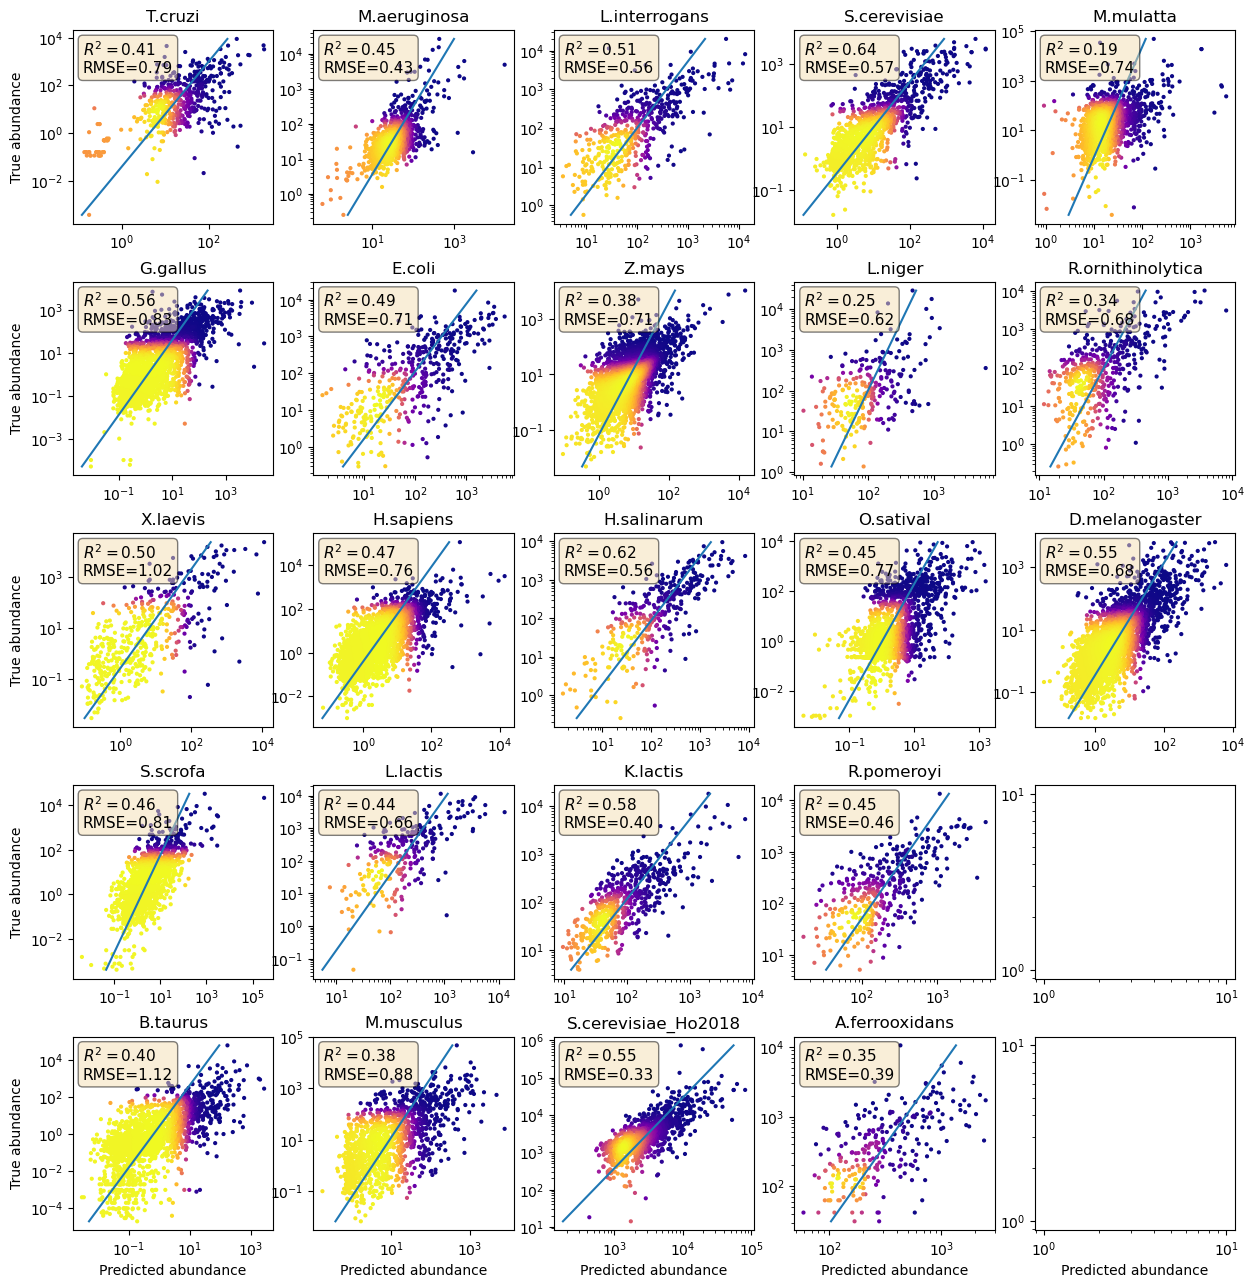

In [26]:
# 'lambda'
from sklearn.linear_model import LinearRegression
#
#"Test_True"
# "train_stat"
fig, axs = plt.subplots(5,5, figsize =[15,15])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
cnt_row = 0
cnt_col = 0

keys = list(dfs.keys())
keys += ["", ""]
for i, key in enumerate(keys):
    if i <23:
        if key == "ho2018":
            abundance = dfs[key]['abundance'].values
        else:
            abundance = np.array(dfs[key]['abundance'])
        
        true = dfs[key]["train_stat"]["Test_True"].numpy()
        eva = dfs[key]["train_stat"]["Test_Eval"].detach().numpy().reshape(-1)
        lam=dfs[key]["lambda"]
        eva_abundance = inv_boxcox(eva, lam)
        true_abundance = inv_boxcox(true, lam)

        model = LinearRegression()

        model.fit(np.log10(true_abundance).reshape(-1, 1), np.log10(eva_abundance.reshape(-1, 1)))
        x = model.predict(np.array([min(np.log10(true_abundance)),max(np.log10(true_abundance))]).reshape(-1, 1))
        
        mse_real_log10 = root_mean_squared_error(np.log10(true_abundance), np.log10(eva_abundance))
        mae_real         = median_absolute_error(true_abundance, eva_abundance)
        r2_real_log10  = r2_score(np.log10(true_abundance), np.log10(eva_abundance))
        
        CoeficientVariation       = np.std(abundance) / np.mean(abundance)
        
        dfs[key]["logSpace_RMSE"] = mse_real_log10
        dfs[key]["RealSpace_MAE"] = mae_real
        dfs[key]["logSpace_R2"] = r2_real_log10
        dfs[key]["RealSpace_CV"]= CoeficientVariation
        dfs[key]["logSpace_CV"]=  CoeficientVariation
        
        print(f"Name: {dfs[key]['Name']}")
        print(f"Real space CV: {CoeficientVariation}")

        scatter_density(eva_abundance, true_abundance, gauss_kern_bandwidth=0.05, ax = axs[cnt_row, cnt_col])
        axs[cnt_row, cnt_col].plot( 10**x, np.array([min(true_abundance),max(true_abundance)]).reshape(-1, 1))
        axs[cnt_row, cnt_col].set_title(f"{dfs[key]['Name']}")

        textstr = '\n'.join((
    r'$R^2=%.2f$' % (r2_real_log10), 
    r'RMSE=%.2f' % (mse_real_log10))) #min(dfs[key]['train_stat']['Training_loss']), )))


        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        
        # place a text box in upper left in axes coords
        axs[cnt_row, cnt_col].text(0.05, 0.95, textstr, transform=axs[cnt_row, cnt_col].transAxes, fontsize=11,
                verticalalignment='top', bbox=props)

    if cnt_row == 4:
        axs[cnt_row, cnt_col].set_xlabel("Predicted abundance")
    else:
        axs[cnt_row, cnt_col].set_xlabel("")
    if cnt_col == 0:
        axs[cnt_row, cnt_col].set_ylabel("True abundance")
    else:
        axs[cnt_row, cnt_col].set_ylabel("")
        
    
    axs[cnt_row, cnt_col].set_xscale("log")
    axs[cnt_row, cnt_col].set_yscale("log")

    cnt_row += 1
    if cnt_row == 5:
        cnt_col += 1
        cnt_row = 0
plt.savefig(f"../../result/2024-0811/scatter_results_training_organisms.png", dpi=600)
plt.show()   

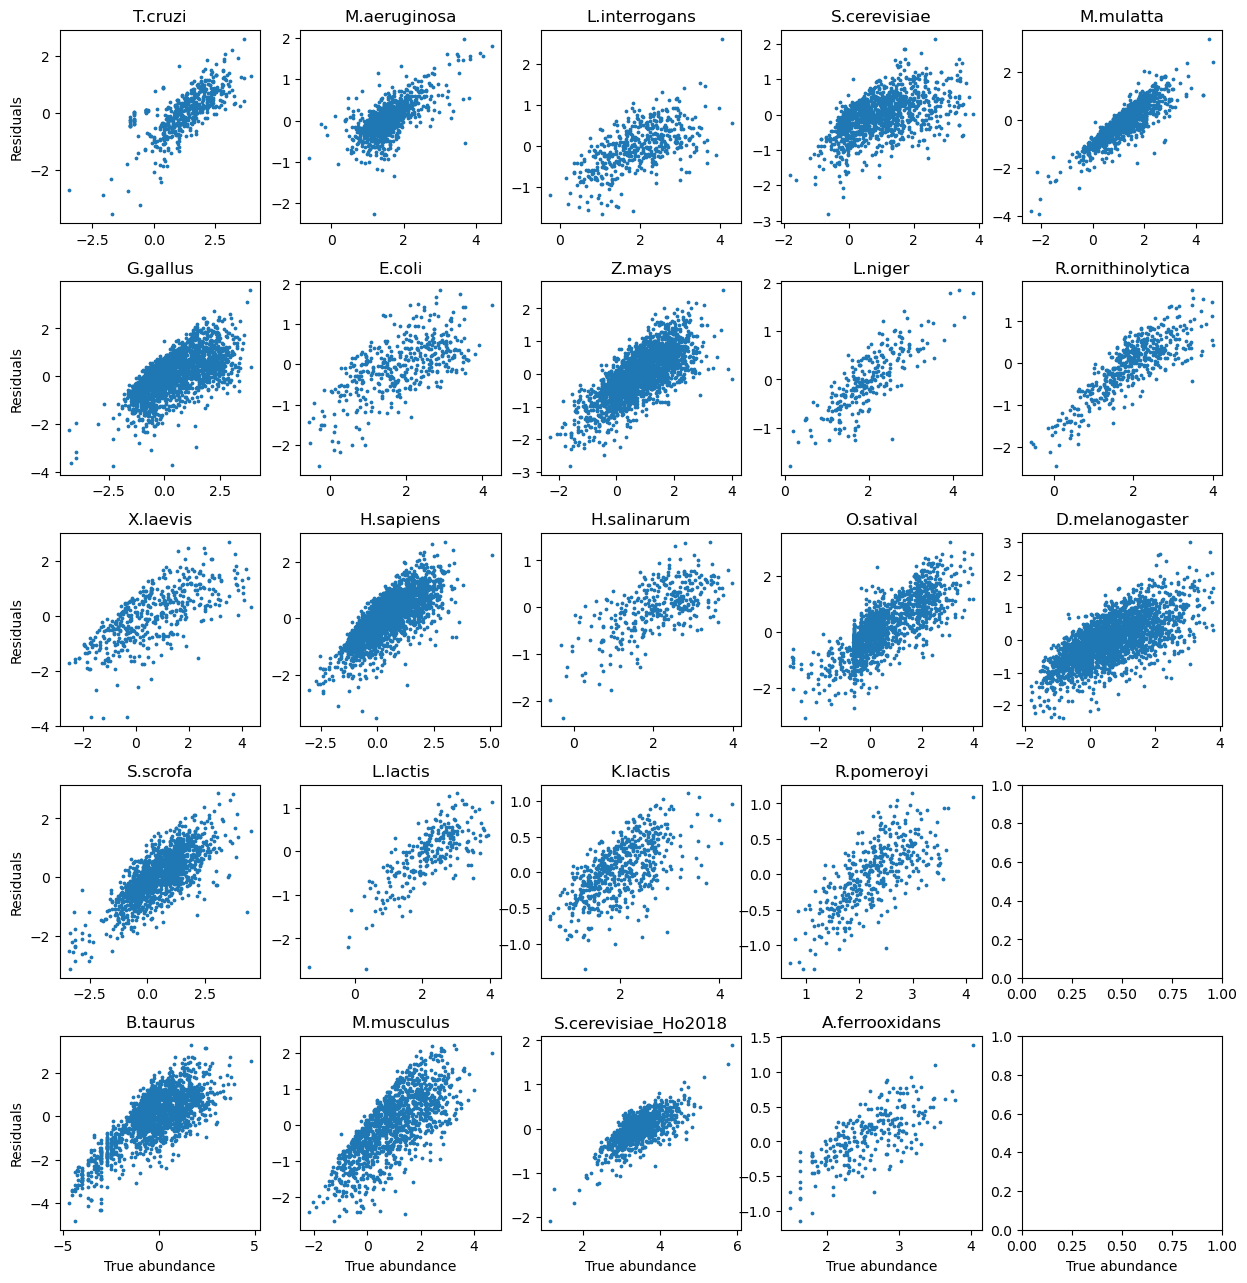

In [7]:

from sklearn.linear_model import LinearRegression
#
#"Test_True"
# "train_stat"
fig, axs = plt.subplots(5,5, figsize =[15,15])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
cnt_row = 0
cnt_col = 0

keys = list(dfs.keys())
keys += ["", ""]
for i, key in enumerate(keys):
    if i <23:
        true = dfs[key]["train_stat"]["Test_True"].numpy()
        eva = dfs[key]["train_stat"]["Test_Eval"].detach().numpy().reshape(-1)
        lam=dfs[key]["lambda"]
        eva_real = np.log10(inv_boxcox(eva, lam))
        true_real = np.log10(inv_boxcox(true, lam))

        idxs = np.argsort(true_real)
        axs[cnt_row, cnt_col].scatter( true_real[idxs], true_real[idxs]- eva_real[idxs], s=3)
        axs[cnt_row, cnt_col].set_title(f"{dfs[key]['Name']}")


    if cnt_row == 4:
        axs[cnt_row, cnt_col].set_xlabel("True abundance")
    else:
        axs[cnt_row, cnt_col].set_xlabel("")
    if cnt_col == 0:
        axs[cnt_row, cnt_col].set_ylabel("Residuals")
    else:
        axs[cnt_row, cnt_col].set_ylabel("")
        
    
    #axs[cnt_row, cnt_col].set_xscale("log")
    #axs[cnt_row, cnt_col].set_yscale("log")

    cnt_row += 1
    if cnt_row == 5:
        cnt_col += 1
        cnt_row = 0
#plt.savefig(f"../../result/2024-0811/scatter_results_training_organisms.png", dpi=600)
plt.show()   
 

# Plot results

In [28]:
kingdom_dict = {"T.cruzi":"Protozoer",
                "G.gallus":"Animalia",
                "X.laevis": "Animalia",
                "S.scrofa": "Animalia",
                "B.taurus": "Animalia",
                "M.aeruginosa": "Bacteria",
                "E.coli": "Bacteria",
                "H.sapiens": "Animalia",
                "L.lactis": "Bacteria",
                "M.tuberculosis": "Bacteria",
                "M.musculus": "Animalia",
                "L.interrogans": "Bacteria",
                "Z.mays": "Plantae",
                "H.salinarum": "Archaea",
                "K.lactis": "Fungi",
                "S.cerevisiae": "Fungi",
                "L.niger": "Animalia",
                "O.satival": "Plantae",
                "R.pomeroyi": "Bacteria",
                "A.ferrooxidans": "Bacteria",
                "M.mulatta": "Animalia",
                "R.ornithinolytica":"Bacteria",
                "D.melanogaster":"Animalia",
                "S.cerevisiae_Ho2018":"Fungi"}


names = []
mse   = []
r2    = []
n_samples=[]
kingdom = []
real_mae = []
real_r2  = []
real_rmse= []
real_CV = []



for item in dfs.items():
   # if item[1]["Name"] == "S.cerevisiae_Ho2018":
   #     print(item[0])
   #     continue
    names.append(item[1]["Name"])
    kingdom.append(kingdom_dict[item[1]["Name"]])
    mse.append(min(item[1]['train_stat']["Test_loss"]))
    r2.append(max(item[1]['train_stat']["Test_r2"]))
    n_samples.append(len(item[1]['id'])*0.2)
    real_mae.append(item[1]['RealSpace_MAE'])
    real_rmse.append(item[1]['logSpace_RMSE'])
    real_r2.append(item[1]['logSpace_R2'])
    real_CV.append(item[1]['RealSpace_CV'])
df={"Name":names, "MSE":mse, "R2":r2, "Group":kingdom, "N_samples":n_samples, "RealSpace_MAE":real_mae, "RealSpace_R2":real_r2, "RealSpace_RMSE":real_rmse, "RealSpace_CV":real_CV}

df = pd.DataFrame(df)

df = df.sort_values(by=["Group", "R2"])
#df = df.sort_values(by="Group")

In [60]:
df.loc[df["R2"]>0.59]

,Name,MSE,R2,Group,N_samples,RealSpace_MAE,RealSpace_R2,RealSpace_RMSE,RealSpace_CV
12,H.salinarum,3.020996,0.640703,Archaea,349.4,94.430531,0.617432,0.557175,2.722714
15,S.cerevisiae,1.283148,0.615421,Fungi,1282.0,4.892758,0.642683,0.573819,5.595513


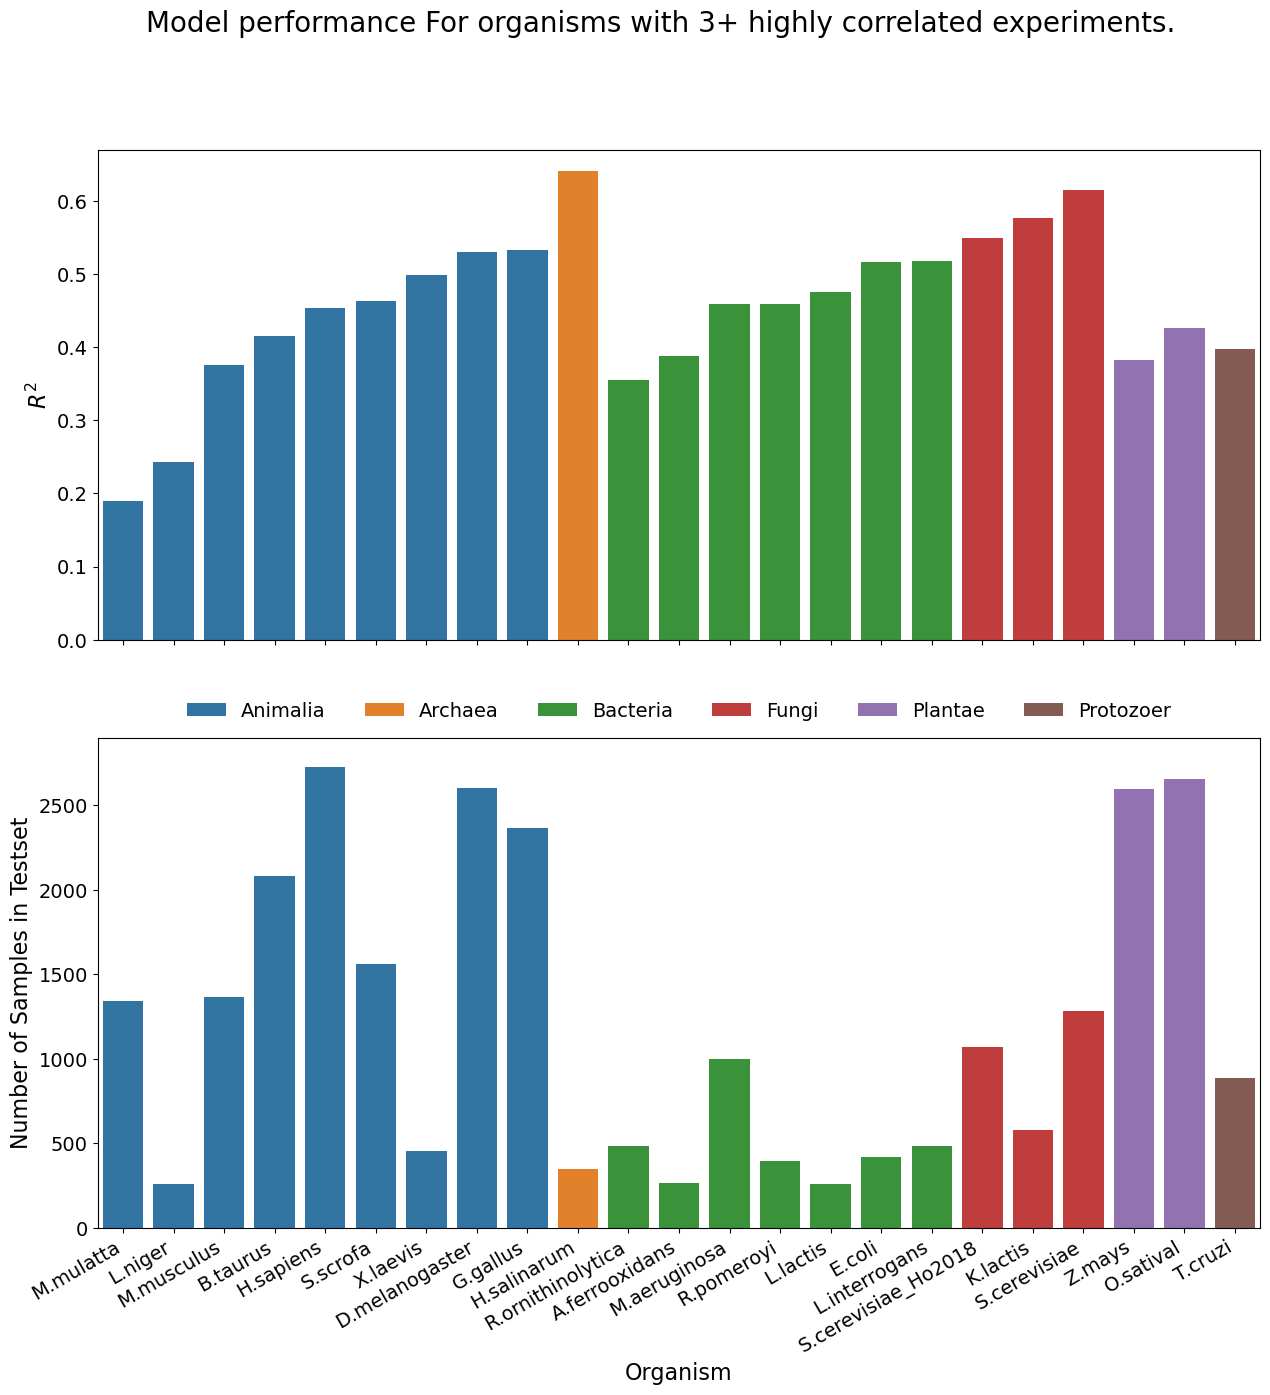

In [29]:
hfont = {'fontname':'Helvetica'}
f, axs = plt.subplots(2, figsize=[15,14])
sns.barplot(data=df, x="Name", y="R2", hue="Group", ax = axs[0], legend=False, )
sns.barplot(data=df, x="Name", y="N_samples", hue="Group", ax=axs[1])
#sns.catplot(
#    data=df, kind="bar",
#    x="Name", y="R2", col="Group",
#    height=4, aspect=.5,
#)
plt.xticks(rotation=30, horizontalalignment="right")
axs[0].set_ylim([0,0.67])
axs[1].set_ylim([0,2900])
f.suptitle("Model performance For organisms with 3+ highly correlated experiments.")
axs[0].set_ylabel(r"$R^2$")
axs[1].set_ylabel(r"Number of Samples in Testset")
#axs[1].set_yscale("log")
axs[1].set_xlabel("Organism")
axs[0].set_xlabel("")
axs[0].set_xticks([i for i in range(df.shape[0])])
axs[0].set_xticklabels(["" for _ in range(df.shape[0])])
sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.5, 1), ncol=6, title=None, frameon=False)
plt.savefig(f"../../result/2024-0811/results_training_organisms_no_ho2018.png", dpi = 600)
plt.show()

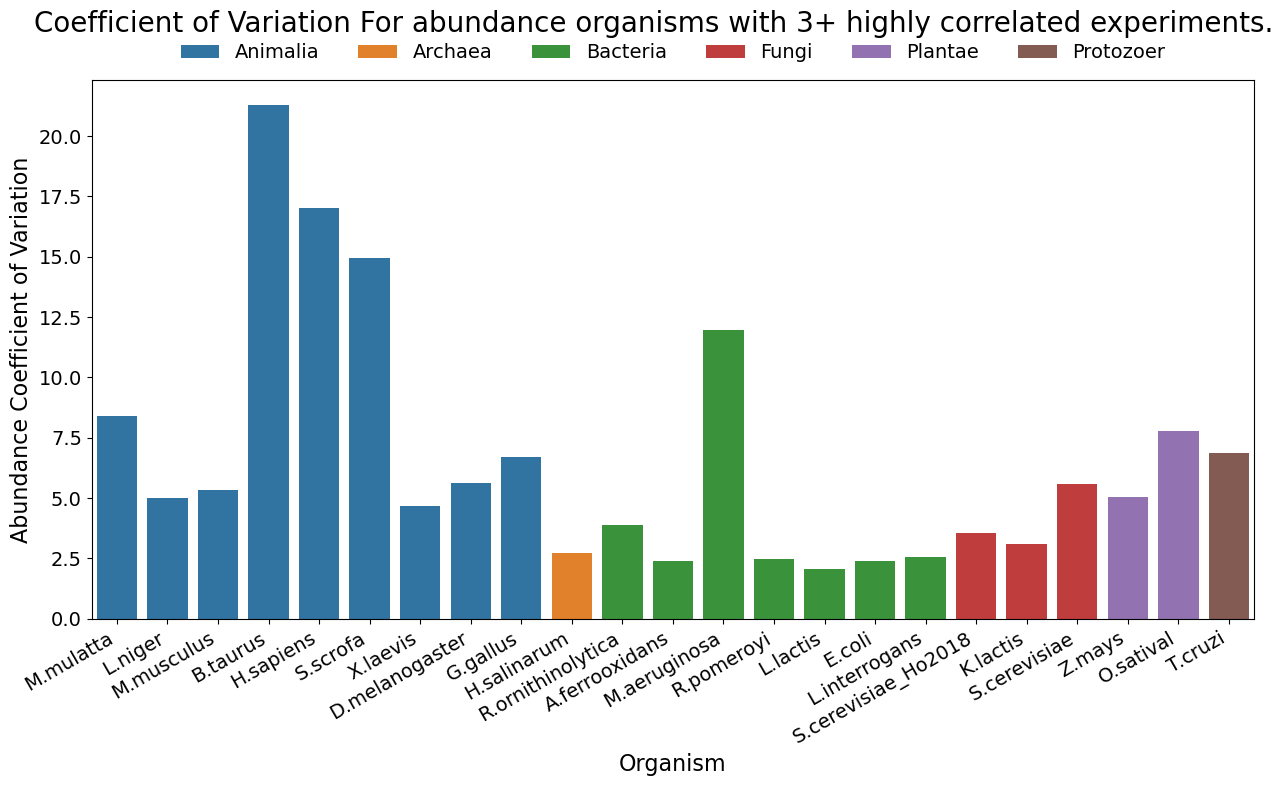

In [32]:
hfont = {'fontname':'Helvetica'}
f, axs = plt.subplots(1, figsize=[15,7])
sns.barplot(data=df, x="Name", y="RealSpace_CV", hue="Group", ax = axs, )

#sns.catplot(
#    data=df, kind="bar",
#    x="Name", y="R2", col="Group",
#    height=4, aspect=.5,
#)
plt.xticks(rotation=30, horizontalalignment="right")
f.suptitle("Coefficient of Variation For abundance organisms with 3+ highly correlated experiments.")
axs.set_ylabel(r"Abundance Coefficient of Variation")

axs.set_xlabel("Organism")
sns.move_legend(axs, "lower center", bbox_to_anchor=(.5, 1), ncol=6, title=None, frameon=False)
plt.savefig(f"../../result/2024-0811/results_CV_organisms.png", dpi = 600, bbox_inches= "tight")
plt.show()

# Train tisue specific 

In [9]:
def read_paxdb_dataset(path) -> pd.DataFrame:
    dset = pd.read_csv(path, sep = '\t', header=11)
    dset = dset.rename(columns = {'#string_external_id': 'id'})
    dset['id'] = dset['id'].map(str)
    dset['id'] = dset['id'].map(lambda s: s.split('.')[1])
    return dset

# Load embeddings
organism = 9606
with open(f"../../data/PaxDb/Paxdb-embedding/{organism}.pkl", "br") as f:
    df_embedding = pkl.load(f)
df_embedding["Embedding"] = df_embedding["Embedding"][:len(df_embedding["id"])]
df_embedding = pd.DataFrame(df_embedding)
df_embedding["id"] = df_embedding.apply(lambda x: x["id"].split(".")[1], axis=1)

# create organ file map


DIRs_abundance = glob.glob(f"../../data/PaxDb/paxdb-abundance-files-v5.0/{organism}/*")
df_organ_file = {}
organs = set()
for file in DIRs_abundance:
    with open(file, "r") as f:
        string = f.read()
        rows = string.split('\n')
    for row in rows:
        if "#organ" in row:
            #print(row)
            organ = row.split()[-1]
            organs.add(organ)
            break
    if organ not in df_organ_file:
        df_organ_file[organ] = [file]
    else:
        df_organ_file[organ].append(file)

#load organ data
dfs = {}
tmp_df = []
#organ = 'LIVER'

for organ in organs:

    for file in df_organ_file[organ]:
        tmp_df.append(read_paxdb_dataset(file))
    
    df = pd.concat(tmp_df)
    df = df.groupby(by="id").median().reset_index()
    df = df_embedding.merge(df, on = "id", how="inner")
    
    if len(df['id']) < 10:
        print(f"File: {file} does not have enoghe entries with: {len(tmp_df['id'])} entries")
        continue
    
    dfs[organ] = {"id": df["id"],
                     "seq": df["seq"],
                     "abundance": df["abundance"],
                     "Embeddings":df["Embedding"]}
    
    X_train, X_test, y_train, y_test = train_test_split(df["Embedding"], df["abundance"], test_size=0.2, random_state=42)
    y_train_transform, lam = boxcox(y_train)
    y_test_transform       = boxcox(y_test, lam)
    
    dfs[organ]["lambda"] = lam
    dfs[organ]["train"] = list(zip(X_train,y_train_transform.astype(np.float32)))
    dfs[organ]["test"] = list(zip(X_test,y_test_transform.astype(np.float32)))
    dfs[organ]["Name"] = organ




Idx:  2 Organism: CELL_LINE has 61 experiments
Idx:  4 Organism: WHOLE_ORGANISM has 8 experiments
Idx:  6 Organism: BRAIN has 7 experiments
Idx:  7 Organism: HEART has 8 experiments
Idx: 11 Organism: LIVER has 11 experiments
Idx: 12 Organism: LUNG has 7 experiments
Idx: 13 Organism: TESTIS has 7 experiments
Idx: 18 Organism: PLASMA has 8 experiments
Idx: 20 Organism: ESOPHAGUS has 7 experiments
Total number of experiments: 124


# train organ models

In [ ]:
Selected_tissues = ["WHOLE_ORGANISM", "BRAIN", "HEART", "LIVER", "LUNG", "PLASMA"]

In [35]:
batch_size = 32
for item in dfs.items():

    print(f"Starting training for organ {item[1]['Name']}")

    organism=item[0]
    df = item[1]
    
    train_set = df["train"]
    test_set = df["test"]
    
    
    
    g = torch.Generator()
    g.manual_seed(0)
    
    
    trainloader = torch.utils.data.DataLoader(
                                            train_set,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                            worker_init_fn=seed_worker,
                                            generator=g,
                                            drop_last=True)
    testloader = torch.utils.data.DataLoader(
                                            test_set,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                            worker_init_fn=seed_worker,
                                            generator=g,
                                            drop_last=True)

    
    
    
    model = Net()
    
    model.to(device="cuda")
    
    criterion = nn.MSELoss()
    metric = R2Score()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    
    train_stat = Train_and_Eval(model,optimizer,criterion, data_train=trainloader, data_test=testloader, metric=metric, n_epochs = 30, name = f'Human/{df["Name"]}.pt')
    dfs[organism]["train_stat"] = train_stat 



KeyError: 'Name'

## Saving model training stats

In [ ]:
#with open(f"../../result/2024-0811/results_training_organ_human.pkl", "bw") as f:
#    pkl.dump(dfs,f)

# Plot results for Human 

## Load dataframe

In [8]:
with open(f"../../result/2024-0811/results_training_organ_human.pkl", "br") as f:
    dfs = pkl.load(f)

/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


## Extract metrics for plot

In [15]:

names = []
mse   = []
r2    = []
n_samples = []
for item in dfs.items():
   
    names.append(item[1]["Name"])
    #kingdom.append(kingdom_dict[item[1]["Name"]])
    mse.append(min(item[1]['train_stat']["Test_loss"]))
    r2.append(max(item[1]['train_stat']["Test_r2"]))
    n_samples.append(len(item[1]['id']))

df={"Name":names, "MSE":mse, "R2":r2, "N_samples":n_samples}#, "Group":kingdom}

df = pd.DataFrame(df)

df = df.sort_values(by=[ "R2"], ascending=False)
#df = df.sort_values(by="Group")

## Plot metrics $R^2$

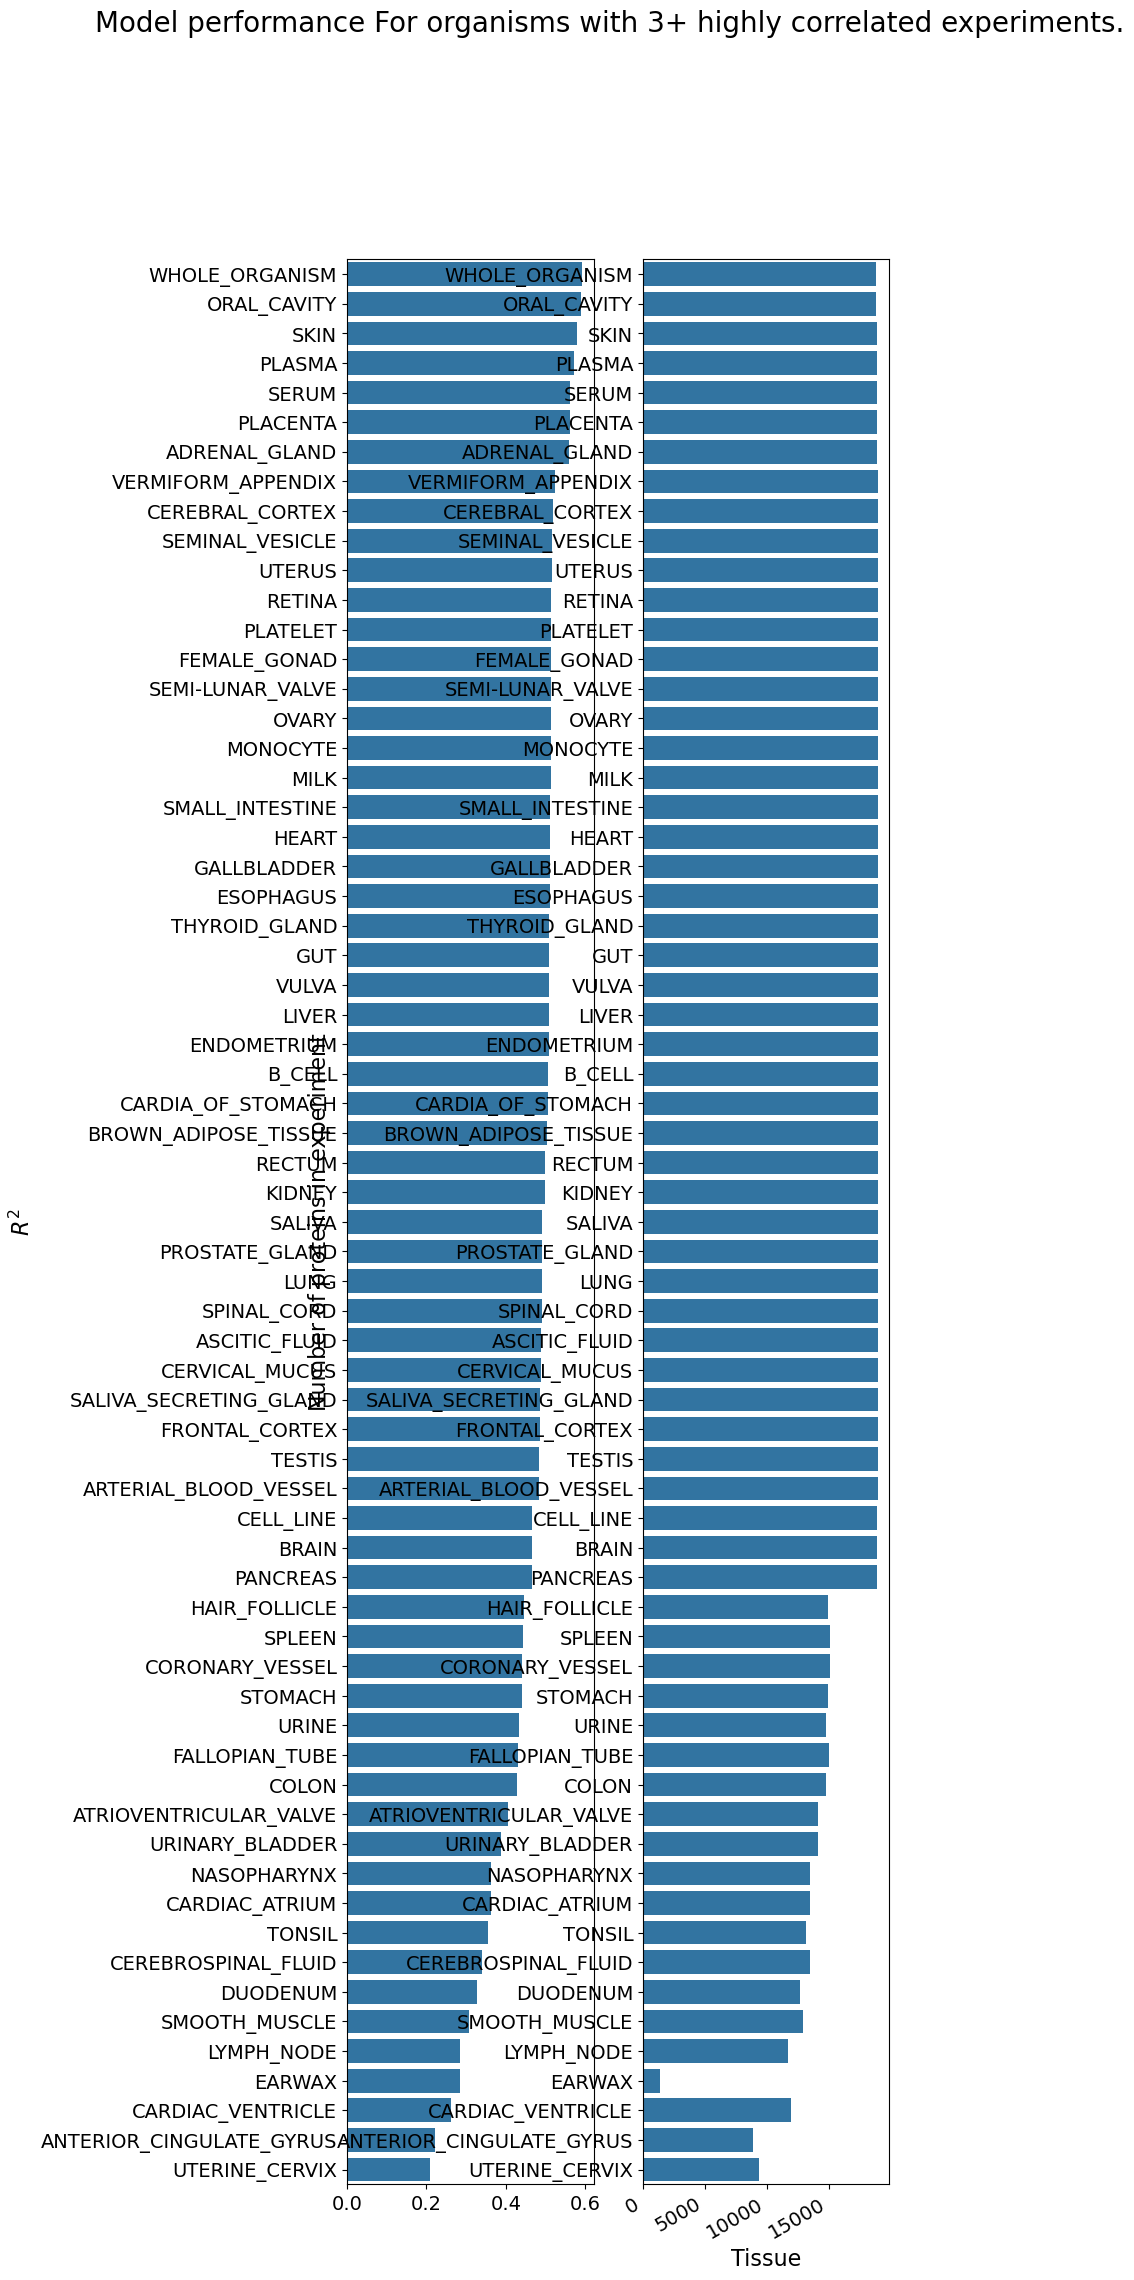

In [18]:
f, axs = plt.subplots(1,2, figsize=[7,25])
sns.barplot(data=df, x="R2", y="Name", ax= axs[0])
sns.barplot(data=df, x="N_samples", y="Name",ax = axs[1])
plt.xticks(rotation=30, horizontalalignment="right")
f.suptitle("Model performance For organisms with 3+ highly correlated experiments.")
axs[0].set_ylabel(r"$R^2$")
axs[1].set_ylabel(r"Number of proteins in experiment")
axs[1].set_xlabel("Tissue")
axs[0].set_xlabel("")
#axs[0].set_xticks([i for i in range(df.shape[0])])
#axs[0].set_xticklabels(["" for _ in range(df.shape[0])])
#sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.5, 1), ncol=6, title=None, frameon=False)
plt.savefig(f"../../result/2024-0811/results_training_organ_Human.png")
plt.show()

# Ploting results organs Mouse

In [5]:
with open(f"../../result/2024-0811/results_training_organ_mouse.pkl", "br") as f:
    dfs = pkl.load(f)
names = []
mse   = []
r2    = []
n_samples = []
for item in dfs.items():
    names.append(item[1]["Name"])
    #kingdom.append(kingdom_dict[item[1]["Name"]])
    mse.append(min(item[1]['train_stat']["Test_loss"]))
    r2.append(max(item[1]['train_stat']["Test_r2"]))
    n_samples.append(len(item[1]['id']))

df={"Name":names, "MSE":mse, "R2":r2, "N_samples":n_samples}#, "Group":kingdom}

df = pd.DataFrame(df)

df = df.sort_values(by=[ "MSE"])
#df = df.sort_values(by="Group")

/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


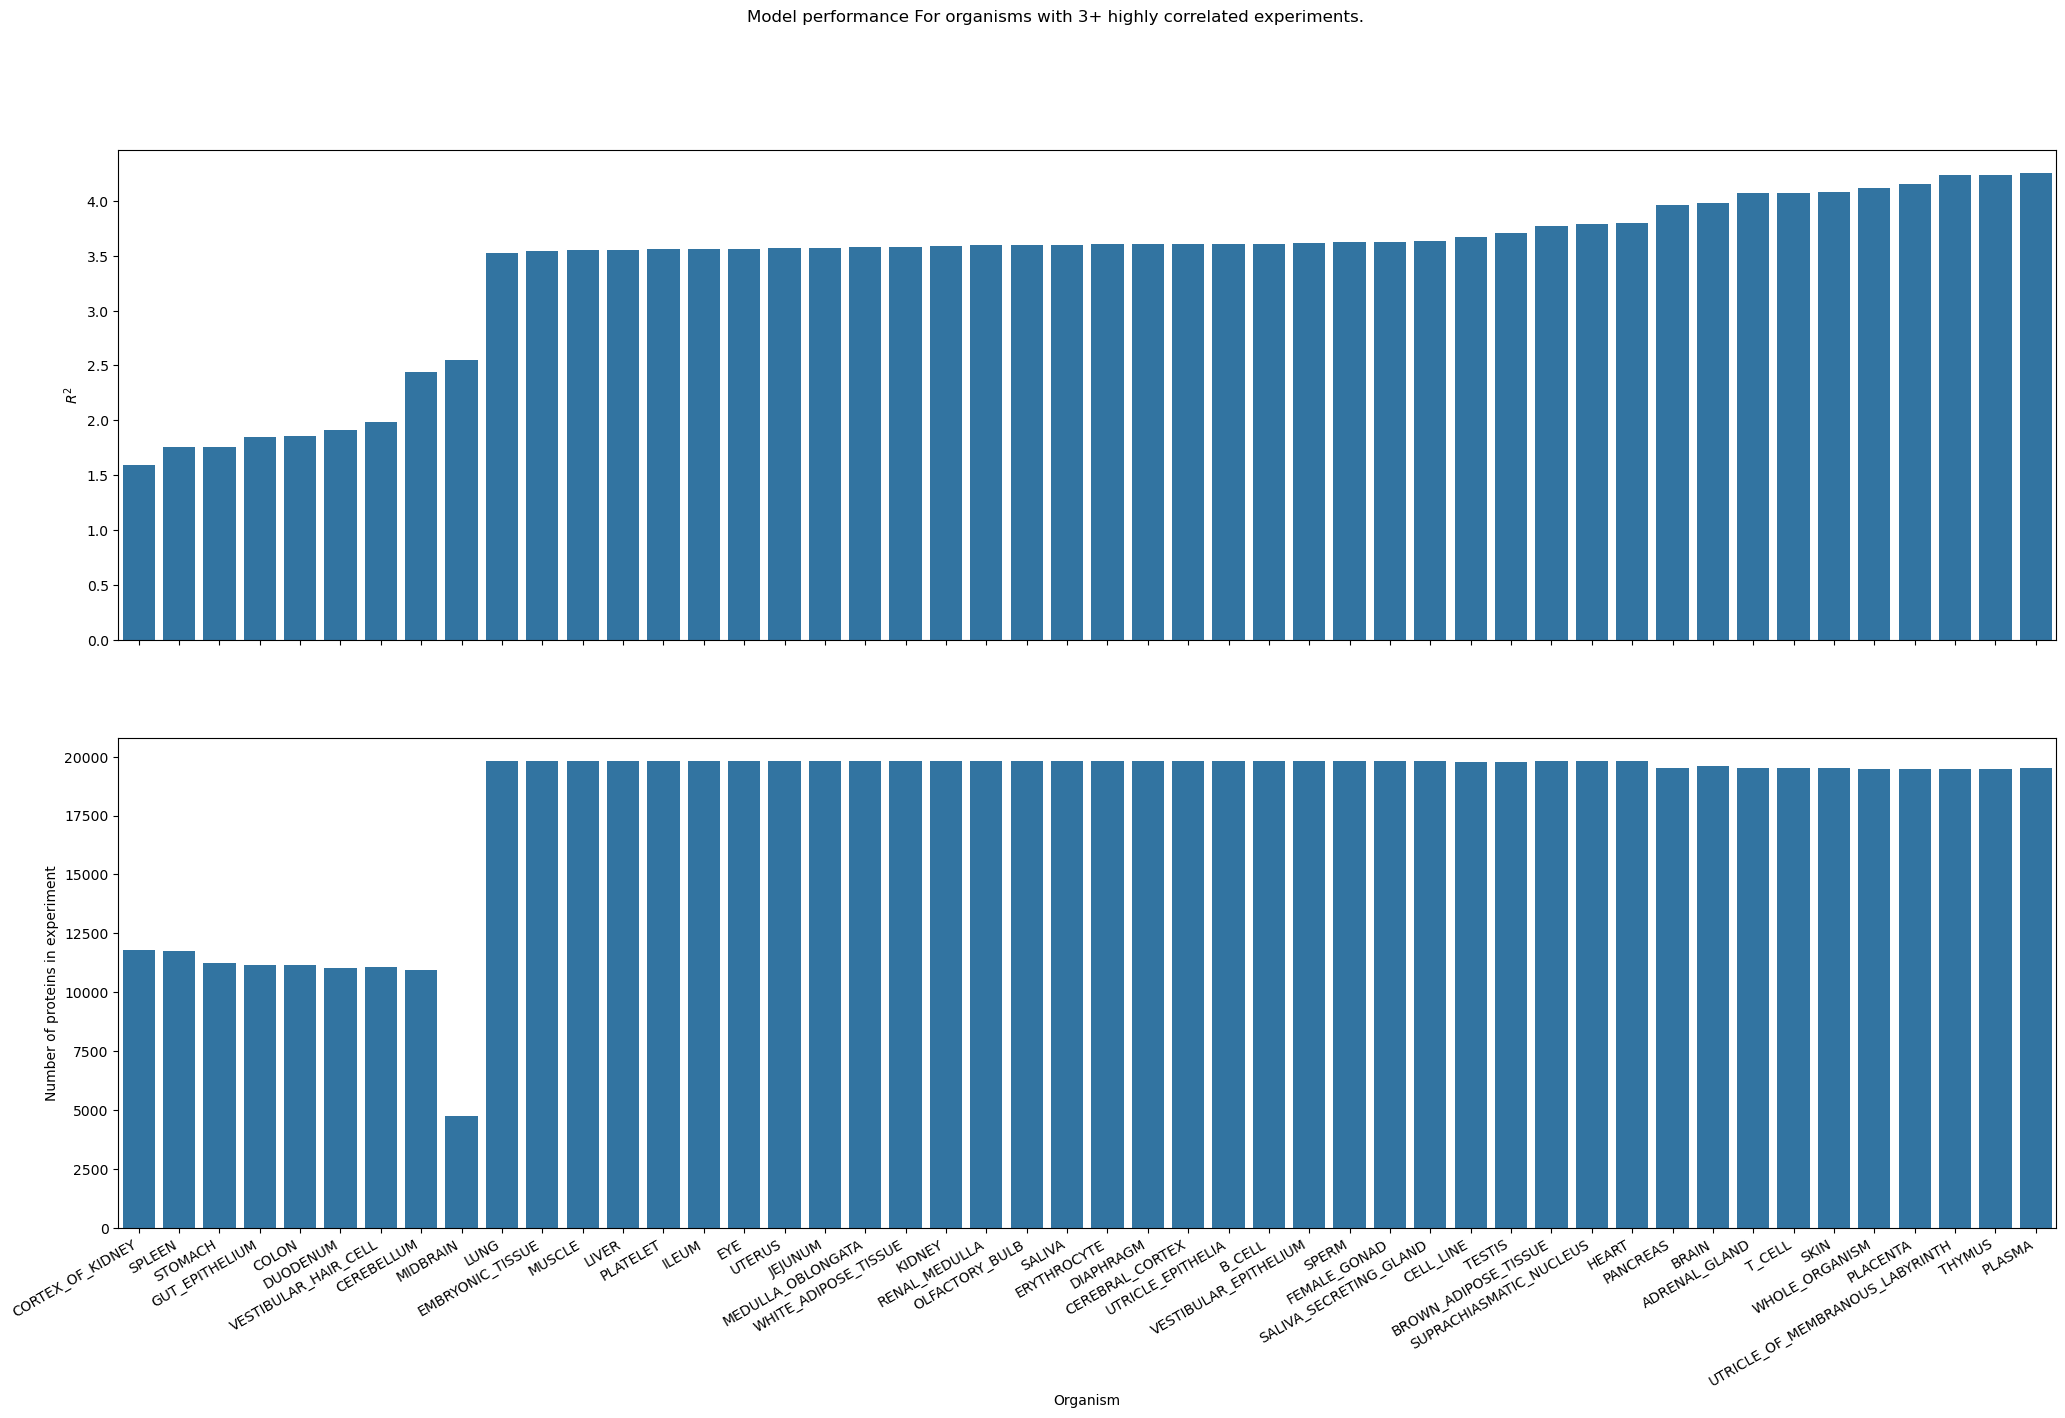

In [6]:
f, axs = plt.subplots(2, figsize=[25,14])
sns.barplot(data=df, x="Name", y="MSE", ax= axs[0])
sns.barplot(data=df, x="Name", y="N_samples",ax = axs[1])
plt.xticks(rotation=30, horizontalalignment="right")
f.suptitle("Model performance For organisms with 3+ highly correlated experiments.")
axs[0].set_ylabel(r"$R^2$")
axs[1].set_ylabel(r"Number of proteins in experiment")
axs[1].set_xlabel("Organism")
axs[0].set_xlabel("")
axs[0].set_xticks([i for i in range(df.shape[0])])
axs[0].set_xticklabels(["" for _ in range(df.shape[0])])
#sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.5, 1), ncol=6, title=None, frameon=False)
plt.savefig(f"../../result/2024-0811/results_training_organ_Mouse.png")
plt.show()

# Check Tissue Experiment dependence

In [13]:
cnt_nExperiments = 0
for idx, item in enumerate(df_organ_file.items()):
    if len(item[1]) > 6:
        
        print(f"Idx: {idx:2d} Organism: {item[0]} has {len(item[1])} experiments")
        cnt_nExperiments += len(item[1])
print(f"Total number of experiments: {cnt_nExperiments}")

Idx:  2 Organism: CELL_LINE has 61 experiments
Idx:  4 Organism: WHOLE_ORGANISM has 8 experiments
Idx:  6 Organism: BRAIN has 7 experiments
Idx:  7 Organism: HEART has 8 experiments
Idx: 11 Organism: LIVER has 11 experiments
Idx: 12 Organism: LUNG has 7 experiments
Idx: 13 Organism: TESTIS has 7 experiments
Idx: 18 Organism: PLASMA has 8 experiments
Idx: 20 Organism: ESOPHAGUS has 7 experiments
Total number of experiments: 124


In [7]:
Selected_tissues = ["WHOLE_ORGANISM", "BRAIN", "HEART", "LIVER", "LUNG", "PLASMA"]

In [17]:

import sklearn


#load organ data
#dfs = {}
tmp_df = []
#organ = 'LIVER'

for organ in Selected_tissues:

    nExperiments = len(df_organ_file[organ])

    #dfs[organ] = {f"Experiment_{i}":{} for i in range(nExperiments)}
    
    print(f"organ is : {organ} with {nExperiments} Experiments")

    for i in range(nExperiments):
        
        trining_experiments = df_organ_file[organ].copy()
        test_experiment = trining_experiments.pop(i)

        
    
        for file in trining_experiments:
            tmp_df.append(read_paxdb_dataset(file))
        
        df_train = pd.concat(tmp_df)
        df_train = df_train.groupby(by="id").median().reset_index()
        df_train = df_embedding.merge(df_train, on = "id", how="inner")
    
        df_test = read_paxdb_dataset(test_experiment)
        df_test = df_test.groupby(by="id").median().reset_index()
        df_test = df_embedding.merge(df_test, on = "id", how="inner")
        
        
        #dfs[organ][f"Experiment_{i}"] = {"Training_Experiments": trining_experiments,
        #                                 "Test_Experiment": test_experiment,
        #                                 "Training_abundance": list(df_train["abundance"]),
        #                                 "Test_abundance": list(df_test["abundance"]),
        #                                 "Embeddings":df_train["Embedding"]}

        df_merg = df_test.merge(df_train, on = "id", suffixes=('_i', '_j'))
        corr, pvalue = stats.pearsonr(df_merg['abundance_i'], df_merg['abundance_j'])
        r2 = sklearn.metrics.r2_score(df_merg['abundance_i'], df_merg['abundance_j'])
        
        
        train_id, test_id, y_train, y_test = train_test_split(df_train["id"].to_list(), df_train["id"].to_list(), test_size=0.2, random_state=42)

        df_train = df_train.loc[df_train["id"].isin(train_id)]
        df_test = df_test.loc[df_test["id"].isin(test_id)]

        y_train = df_train["abundance"].values
        y_test = df_test["abundance"].values
        
        y_train_transform, lam = boxcox(y_train)
        y_test_transform       = boxcox(y_test, lam)

        if y_test_transform.shape[0] < 64:
            dfs[organ][f"Experiment_{i}"]=None
            continue
        assert y_test_transform.shape[0] > 64
        
        X_train = df_train["Embedding"].values
        X_test = df_test["Embedding"].values
        
        dfs[organ][f"Experiment_{i}"]["lambda"] = lam
        dfs[organ][f"Experiment_{i}"]["train"] = list(zip(X_train,y_train_transform.astype(np.float32)))
        dfs[organ][f"Experiment_{i}"]["test"] = list(zip(X_test,y_test_transform.astype(np.float32)))
        dfs[organ][f"Experiment_{i}"]["Name"] = organ
        dfs[organ][f"Experiment_{i}"]["Test_Correlation"] = corr
        dfs[organ][f"Experiment_{i}"]["Test_r2"] = r2



organ is : WHOLE_ORGANISM with 8 Experiments
organ is : BRAIN with 7 Experiments
organ is : HEART with 8 Experiments
organ is : LIVER with 11 Experiments
organ is : LUNG with 7 Experiments
organ is : PLASMA with 8 Experiments


In [16]:
batch_size = 32
for item in dfs.items():
     
    tissue=item[0]
    print(f"Starting training for organ {item[0]}")

    for experiment in  item[1].items():
        if experiment[1] == None:
            continue
        experiment_number = experiment[0]
        df = experiment[1]

    

    
        train_set = df["train"]
        test_set = df["test"]
        g = torch.Generator()
        g.manual_seed(0)
        trainloader = torch.utils.data.DataLoader(
                                                train_set,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2,
                                                worker_init_fn=seed_worker,
                                                generator=g,
                                                drop_last=True)
        testloader = torch.utils.data.DataLoader(
                                                test_set,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2,
                                                worker_init_fn=seed_worker,
                                                generator=g,
                                                drop_last=True)
        testloader_2 = torch.utils.data.DataLoader(
                                            test_set,
                                            batch_size=len(test_set),
                                            shuffle=False,
                                            num_workers=2,
                                            worker_init_fn=seed_worker,
                                            generator=g,
                                            drop_last=False)
        
        
        
        model = Net()
        model.to(device="cuda")
    
        criterion = nn.MSELoss()
        metric = R2Score()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        
        train_stat = Train_and_Eval(model,optimizer,criterion, data_train=trainloader, data_test=testloader, metric=metric, n_epochs = 30, name = f'Human_TEST/{tissue}_{experiment_number}.pt',test_data=testloader_2)
        dfs[tissue][experiment_number]["train_stat"] = train_stat 
    
with open(f"../../result/2024-0811/results_training_organ_human_deepTest.pkl", "bw") as f:
    pkl.dump(dfs,f)

Starting training for organ WHOLE_ORGANISM
Epoch:   0, Training Loss: 4.3320, Train R2 0.4525, Test Loss: 8.5830, Test R2 -2.3557
Epoch:   1, Training Loss: 3.7452, Train R2 0.5266, Test Loss: 9.6821, Test R2 -2.7925
Epoch:   2, Training Loss: 3.6242, Train R2 0.5418, Test Loss: 8.3653, Test R2 -2.2829
Epoch:   3, Training Loss: 3.4946, Train R2 0.5580, Test Loss: 9.5307, Test R2 -2.7436
Epoch:   4, Training Loss: 3.4156, Train R2 0.5681, Test Loss: 8.7441, Test R2 -2.4172
Epoch:   5, Training Loss: 3.3224, Train R2 0.5801, Test Loss: 7.1901, Test R2 -1.8411
Epoch:   6, Training Loss: 3.2547, Train R2 0.5881, Test Loss: 8.7301, Test R2 -2.4110
Epoch:   7, Training Loss: 3.1801, Train R2 0.5978, Test Loss: 8.9844, Test R2 -2.5106
Epoch:   8, Training Loss: 3.1150, Train R2 0.6062, Test Loss: 8.0624, Test R2 -2.1747
Epoch:   9, Training Loss: 3.0619, Train R2 0.6127, Test Loss: 11.7486, Test R2 -3.6121
Epoch:  10, Training Loss: 2.9748, Train R2 0.6238, Test Loss: 11.1244, Test R2 -3.328

/tmp/ipykernel_2437314/3114533569.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../../result/2024-0811/models/{name}")


Epoch:   0, Training Loss: 4.3073, Train R2 0.4505, Test Loss: 4.9589, Test R2 0.4893
Epoch:   1, Training Loss: 3.7401, Train R2 0.5223, Test Loss: 4.6685, Test R2 0.5191
Epoch:   2, Training Loss: 3.6125, Train R2 0.5389, Test Loss: 4.8482, Test R2 0.4993
Epoch:   3, Training Loss: 3.4942, Train R2 0.5540, Test Loss: 4.8757, Test R2 0.4984
Epoch:   4, Training Loss: 3.4259, Train R2 0.5626, Test Loss: 4.8926, Test R2 0.4960
Epoch:   5, Training Loss: 3.3246, Train R2 0.5758, Test Loss: 4.6087, Test R2 0.5239
Epoch:   6, Training Loss: 3.2849, Train R2 0.5809, Test Loss: 4.6814, Test R2 0.5176
Epoch:   7, Training Loss: 3.1870, Train R2 0.5933, Test Loss: 4.6849, Test R2 0.5174
Epoch:   8, Training Loss: 3.1092, Train R2 0.6032, Test Loss: 4.5845, Test R2 0.5276
Epoch:   9, Training Loss: 3.0759, Train R2 0.6075, Test Loss: 4.7844, Test R2 0.5062
Epoch:  10, Training Loss: 3.0073, Train R2 0.6163, Test Loss: 4.6871, Test R2 0.5159
Epoch:  11, Training Loss: 2.9268, Train R2 0.6265, Te

In [37]:
#with open(f"../../result/2024-0811/results_training_organ_human_deepTest.pkl", "bw") as f:
#    pkl.dump(dfs,f)

In [10]:
with open(f"../../result/2024-0811/results_training_organ_human_deepTest.pkl", "br") as f:
    dfs = pkl.load(f)

/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [21]:
df_corr = {"Tissue":[], "Experiment":[],"Correlation":[],"Model_R2":[]}
for tissue in dfs.items():
    for experiment in tissue[1].items():
        if experiment[1]==None:
            continue
        df_corr["Tissue"].append(tissue[0]) #]experiment[1][""])
        df_corr["Experiment"].append(experiment[0])
        df_corr["Correlation"].append(experiment[1]["Test_Correlation"])
        df_corr["Model_R2"].append(experiment[1]["Test_r2"])


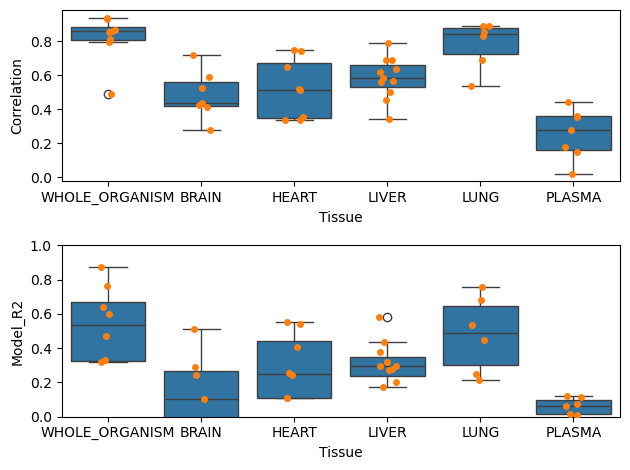

In [23]:




fig, ax = plt.subplots(2)


sns.boxplot(data=df_corr, x="Tissue", y="Correlation", ax=ax[0])
sns.stripplot(data=df_corr, x="Tissue", y="Correlation", ax=ax[0])
sns.boxplot(data=df_corr, x="Tissue", y="Model_R2", ax = ax[1])
sns.stripplot(data=df_corr, x="Tissue", y="Model_R2", ax=ax[1])
ax[1].set_ylim([0, 1])
#ax[1].set_yticks([-25,-1,0,0.2,0.4,0.6,0.8,1.0])
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [1]:
1900000 //4096

463

In [8]:
for step, _ in enumerate(range(100)):
    if (step+1) % 4 == 0:
        print(f"acum at step: {step}")

acum at step: 3
acum at step: 7
acum at step: 11
acum at step: 15
acum at step: 19
acum at step: 23
acum at step: 27
acum at step: 31
acum at step: 35
acum at step: 39
acum at step: 43
acum at step: 47
acum at step: 51
acum at step: 55
acum at step: 59
acum at step: 63
acum at step: 67
acum at step: 71
acum at step: 75
acum at step: 79
acum at step: 83
acum at step: 87
acum at step: 91
acum at step: 95
acum at step: 99
